In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/PHD/SemEval2023

/content/gdrive/MyDrive/PHD/SemEval2023


In [3]:
!git clone git@github.com:SirBadr/SemEval2022-Task10.git

Cloning into 'SemEval2022-Task10'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [3]:
import pandas as pd
# unsupervised_data_gab = pd.read_csv("Data/starting_ki/gab_1M_unlabelled.csv")
# unsupervised_data_reddit = pd.read_csv("Data/starting_ki/reddit_1M_unlabelled.csv")

In [4]:
from sklearn.model_selection import train_test_split

target_column = "label_category"
data = pd.read_csv("Data/starting_ki/train_all_tasks.csv")
data = data[data[target_column]!="none"]

train, test = train_test_split(data, test_size=0.2, random_state=42)
# data = train

In [5]:
if target_column == "label_category":
  label_values = [
      '1. threats, plans to harm and incitement',
      '2. derogation',
      '3. animosity',
      '4. prejudiced discussions',
  ]

#   label_map = {
#       0: '1. threats, plans to harm and incitement',
#       1: '2. derogation', 
#       2: '3. animosity', 
#       3: '4. prejudiced discussions',
#       '1. threats, plans to harm and incitement':0,
#       '2. derogation':1,
#       '3. animosity':2,
#       '4. prejudiced discussions':3,
#   }
elif target_column == "label_vector":
  label_values = [
      '1.1 threats of harm',
      '1.2 incitement and encouragement of harm',
      '2.1 descriptive attacks',
      '2.2 aggressive and emotive attacks',
      '2.3 dehumanising attacks & overt sexual objectification',
      '3.1 casual use of gendered slurs, profanities, and insults',
      '3.2 immutable gender differences and gender stereotypes',
      '3.3 backhanded gendered compliments',
      '3.4 condescending explanations or unwelcome advice',
      '4.1 supporting mistreatment of individual women',
      '4.2 supporting systemic discrimination against women as a group',
  ]

#   label_map = {
#       0: '1.1 threats of harm',
#       1: '1.2 incitement and encouragement of harm',
#       2: '2.1 descriptive attacks',
#       3: '2.2 aggressive and emotive attacks',
#       4: '2.3 dehumanising attacks & overt sexual objectification',
#       5: '3.1 casual use of gendered slurs, profanities, and insults',
#       6: '3.2 immutable gender differences and gender stereotypes',
#       7: '3.3 backhanded gendered compliments',
#       8: '3.4 condescending explanations or unwelcome advice',
#       9: '4.1 supporting mistreatment of individual women',
#       10: '4.2 supporting systemic discrimination against women as a group',
#       '1.1 threats of harm': 0,
#       '1.2 incitement and encouragement of harm': 1,
#       '2.1 descriptive attacks': 2,
#       '2.2 aggressive and emotive attacks': 3,
#       '2.3 dehumanising attacks & overt sexual objectification': 4,
#       '3.1 casual use of gendered slurs, profanities, and insults': 5,
#       '3.2 immutable gender differences and gender stereotypes': 6,
#       '3.3 backhanded gendered compliments': 7,
#       '3.4 condescending explanations or unwelcome advice': 8,
#       '4.1 supporting mistreatment of individual women': 9,
#       '4.2 supporting systemic discrimination against women as a group': 10,
#   }
# else:
#   raise Exception("Unknown label column")

## Shapley

In [6]:
!pip install -q transformers shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.4 MB/s eta 0:00:00


In [7]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
import torch
from transformers import BertForSequenceClassification, AdamW, BertConfig

out_dir = f'./Models/1a_fine-tuned-bert'
model = BertForSequenceClassification.from_pretrained(out_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [9]:
import transformers
import torch
import numpy as np
import scipy as sp

In [10]:
texts = train['text'].values

In [11]:
import shap
# define a prediction function
def f(texts):
  text_ids = [tokenizer.encode(text, max_length=100, padding='max_length', truncation=True) for text in texts]

  att_masks = []
  for ids in text_ids:
      masks = [int(id > 0) for id in ids]
      att_masks.append(masks)

  text_ids = torch.tensor(text_ids).to(device)
  att_masks = torch.tensor(att_masks).to(device)

  outputs = model(text_ids, attention_mask=att_masks)
  outputs = outputs[0].detach().cpu().numpy()
  scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
  
  val = sp.special.logit(scores[:,1]) # use one vs rest logit units
  return val

In [12]:
for label in label_values:
  print(label)

1. threats, plans to harm and incitement
2. derogation
3. animosity
4. prejudiced discussions


In [ ]:
# import pickle

# def save_shap_values(filepath, obj):
#   with open(filepath, 'wb') as fin:
#     pickle.dump(obj, fin)

# def save_lexicons(filepath, obj):
#   with open(filepath, 'w', encoding="utf-8") as fin:
#     for w in obj:
#       fin.write(str(w)+"\n")

# def get_lexicons(shap_values):
#   feature_names = shap_values.abs.mean(0).feature_names
#   shapley_values = shap_values.abs.mean(0).values

#   candidates = [x for v, x in sorted(zip(shapley_values, feature_names), key=lambda pair: -pair[0]) if v > 0]
#   return candidates
    

# explainer = shap.Explainer(f, tokenizer)

# shap_values = {}
# lexicons = {}
# for idx, label in enumerate(label_values):
#   print("Working on", label)
#   d = train[train["label_category"]==label]
#   print("#Rows", len(d))
#   d = {"text": d["text"].values}
  
#   shap_values[label] = explainer(d, fixed_context=1, batch_size=256)
#   save_shap_values(f"./Results/shapley_values_{idx+1}.pickle", shap_values[label])
#   lexicons[label] = get_lexicons(shap_values[label])
#   save_lexicons(f"./Results/shapley_lexicon_{idx+1}.txt", lexicons[label])
#   print("")


# # Working on 1. threats, plans to harm and incitement
# # #Rows 253
# # Partition explainer: 254it [01:52,  2.13it/s]
# # Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

# # Working on 2. derogation
# # #Rows 1262
# # Partition explainer: 1263it [10:06,  2.05it/s]

# # Working on 3. animosity
# # #Rows 938
# # Partition explainer: 939it [07:28,  2.04it/s]

# # Working on 4. prejudiced discussions
# # #Rows 265
# # Partition explainer: 266it [02:18,  1.75it/s]


Working on 1. threats, plans to harm and incitement
#Rows 253


Partition explainer: 254it [01:52,  2.13it/s]
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Working on 2. derogation
#Rows 1262


Partition explainer: 1263it [10:06,  2.05it/s]



Working on 3. animosity
#Rows 938


Partition explainer: 939it [07:28,  2.04it/s]



Working on 4. prejudiced discussions
#Rows 265


Partition explainer: 266it [02:18,  1.75it/s]


In [57]:
import pickle

def load_shap_values(filepath):
  with open(filepath, 'rb') as fin:
    obj = pickle.load(fin)
  return obj

def get_lexicons(shap_values):
  feature_names = shap_values.abs.mean(0).feature_names
  shapley_values = shap_values.abs.mean(0).values

  sorted_values = sorted(zip(shapley_values, feature_names), key=lambda pair: -pair[0])
  features = [x for v, x in sorted_values]
  values = {x:v for v, x in sorted_values}
  return features, values
  
shap_values = {}
lexicons = {}
lexicons_score = {}
for idx, label in enumerate(label_values):
  shap_values[label] = load_shap_values(f"./Results/shapley_values_{idx+1}.pickle")
  k, v = get_lexicons(shap_values[label])
  lexicons[label] = k
  lexicons_score[label] = v

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Category 1. threats, plans to harm and incitement


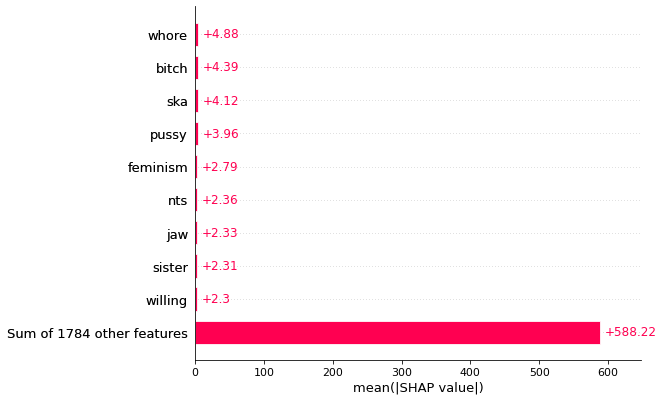

In [ ]:
print("Category", label_values[0])
shap.plots.bar(shap_values[label_values[0]].abs.mean(0))

Category 2. derogation


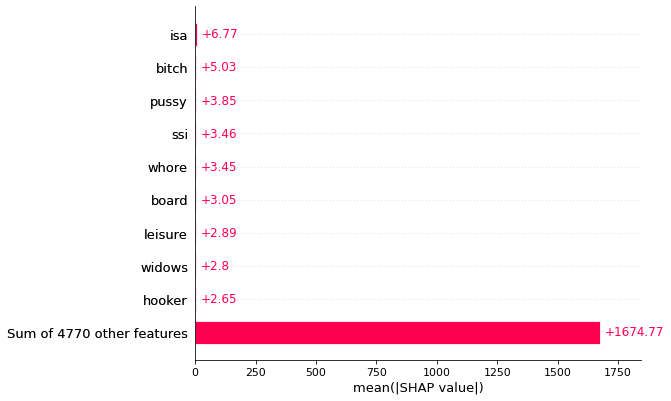

In [ ]:
print("Category", label_values[1])
shap.plots.bar(shap_values[label_values[1]].abs.mean(0))

Category 3. animosity


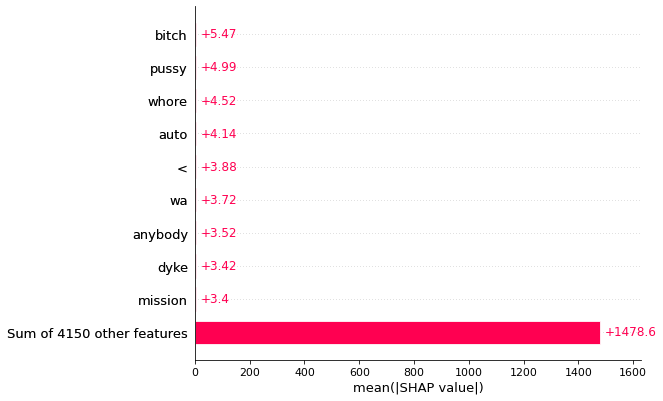

In [ ]:
print("Category", label_values[2])
shap.plots.bar(shap_values[label_values[2]].abs.mean(0))

Category 4. prejudiced discussions


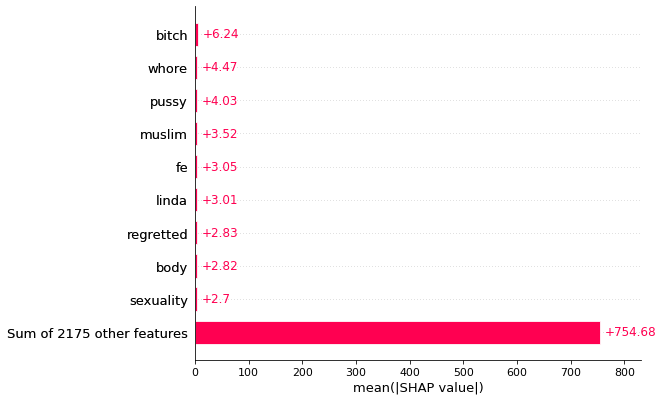

In [ ]:
print("Category", label_values[3])
shap.plots.bar(shap_values[label_values[3]].abs.mean(0))

In [62]:
# lexicons["2. derogation"]

## Evaluation

In [58]:
test_labels = test[target_column].values

In [60]:
test_texts = test["text"].values
test_words = [tokenizer.tokenize(t) for t in test_texts]

In [77]:
from sklearn.metrics import f1_score

def predict(word, lexicons):
  cnt = {}
  for label in label_values:
    cnt[label] = 0

  for w in word:
    w = w.replace("#", "")
    for label in label_values:
      if w in lexicons[label]:
        cnt[label] += lexicons_score[label][w]

  
  if sum(cnt.values())==0:
    return None
  
  return max(cnt.items(), key=lambda k: k[1])[0]

y_pred = []
y_test = []
non = 0
for word, label in zip(test_words, test_labels):
  pred = predict(word, lexicons)
  if pred is None:
    non += 1
    continue

  y_pred.append(pred)
  y_test.append(label)

print("F1:", f1_score(y_test, y_pred, average='macro'))
print("Skip:", non/len(test_words))

F1: 0.33489272588061714
Skip: 0.0


In [ ]:
# lexicon_values = {}
# lexicon_keys = {}
# for l in lexicons:
#   lexicon_values[l] = {}
#   lexicon_keys[l] = set()
#   for v, w in lexicons[l]:
#     lexicon_keys[l].add(w)
#     lexicon_values[l][w] = v


# def predict(word, lexicon_values, lexicon_keys):
#   cnt = {}
#   for label in label_values:
#     cnt[label] = 0

#   for w in word:
#     for label in label_values:
#       if w in lexicon_keys[label]:
#         cnt[label] += lexicon_values[label][w]

  
#   if sum(cnt.values())==0:
#     return None
  
#   return max(cnt.items(), key=lambda k: k[1])[0]

# y_pred = []
# y_test = []
# non = 0
# for word, label in zip(test_words, test_labels):
#   pred = predict(word, lexicon_values, lexicon_keys)
#   if pred is None:
#     non += 1
#     continue

#   y_pred.append(pred)
#   y_test.append(label)

# print("F1:", f1_score(y_test, y_pred, average='macro'))
# print("Skip:", non/len(test_words))

# Handle subwords

In [ ]:
import nltk
nltk.download('punkt')

In [76]:
feature_names = shap_values[label].abs.mean(0).feature_names
for f in feature_names:
  if "#" in f:
    print(f)

#


In [193]:
from collections import defaultdict

def map_subwords(words, subwords):
  sidx = 0
  widx = 0
  w = ""
  mapping = []
  while widx < len(words):
    w = w + words[widx]
    if sidx >= len(subwords):
      print(widx, w, sidx)
      print(words)
      print(subwords)

    idx = [sidx]
    s = subwords[sidx].replace("#", "")

    while len(w) < len(s):
      widx += 1
      w = w + words[widx].strip()

    # if words[0] == "layin":
    #     print(w, s)

    while s!=w and len(s) < len(w) and sidx+1 < len(subwords):
      sidx += 1
      s += subwords[sidx].replace("#", "").strip()
      idx.append(sidx)

      # if words[0] == "layin":
      #   print(f"[{w}] [{s}]", len(w), len(s), w==s)

    if len(s) > len(w):
      widx += 1
      sidx -= len(idx) - 1
      continue
      
    sidx += 1
    # print(w, s, idx)
    widx += 1
    w = ""

    mapping.append(idx)

  return mapping
  
vocabs = {}
new_lexicons_keys = {}
new_lexicons_scores = {}

for idx, label in enumerate(label_values):
  print("Working on", label)
  new_lexicons = defaultdict(int)
  vocabs[label] = set()

  d = train[train["label_category"]==label]
  texts = d["text"].values
  for sent in texts:
    sent = sent.lower().replace("#", "").replace("''", '"')
 
    sent = sent.encode("ascii", "ignore")
    sent = sent.decode()
    # sent = sent.replace("``", '"')
    # sent = sent.replace("`", "'")
    
    words = nltk.word_tokenize(sent)
    for widx, w in enumerate(words):
      if w=="``":
        words[widx] = '"'
        continue
      elif w=="''":
        words[widx] = '"'
        continue
    
    for w in words:
      vocabs[label].add(w)
      
    subwords = tokenizer.tokenize(sent)
  
    for sidx, s in enumerate(subwords):
      if s=="``":
        subwords[sidx] = '"'
        continue
      elif s=="''":
        subwords[sidx] = '"'
        continue

    idxs = map_subwords(words, subwords)

    
    
    for idx in idxs:
      w = ""
      s = 0
      for i in idx:
        sw = subwords[i].replace("#", "")
        w += sw
        if sw not in lexicons_score[label]:
          print(">>", sw)
          continue

        s += lexicons_score[label][sw]
        
      new_lexicons[w] = s
      # new_lexicons[w].append(s)
  
  sorted_list = sorted(new_lexicons.items(), key=lambda item: -item[1])
  new_lexicons_scores[label] = { k:v for k, v in sorted_list if v > 0}
  new_lexicons_keys[label] = [k for k, v in sorted_list if v > 0]

Working on 1. threats, plans to harm and incitement
>> lets
Working on 2. derogation
>> shell
>> shell
>> rso
Working on 3. animosity
>> mn
>> shed
Working on 4. prejudiced discussions
>> girlfriends
>> ln
>> ill
>> ding
>> iv


In [195]:
for l in vocabs:
  print(l, len(vocabs[l]))

1. threats, plans to harm and incitement 1734
2. derogation 5170
3. animosity 4424
4. prejudiced discussions 2092


In [158]:
test_texts = test["text"].values
test_words = [nltk.word_tokenize(t.lower()) for t in test_texts]

In [220]:
threshold = {}
for l in new_lexicons_scores:
  values = [v for k, v in new_lexicons_scores[l].items()]
  threshold[l] = np.quantile(values, 0.9)

# print(threshold)

lexicon_values = {}
lexicon_keys = {}
for l in new_lexicons_scores:
  lexicon_values[l] = {}
  lexicon_keys[l] = set()
  for w in new_lexicons_scores[l]:
    v = new_lexicons_scores[l][w]

    if v > threshold[l]:
      lexicon_keys[l].add(w)
      lexicon_values[l][w] = v
  print(l, len(lexicon_keys[l]), len(lexicon_keys[l])/len(vocabs[l]))

1. threats, plans to harm and incitement 174 0.10034602076124567
2. derogation 518 0.10019342359767891
3. animosity 444 0.1003616636528029
4. prejudiced discussions 210 0.10038240917782026


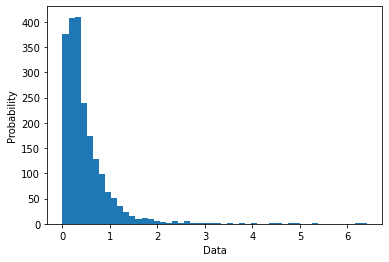

In [221]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(values, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [222]:
def predict(word, lexicon_values, lexicon_keys):
  cnt = {}
  for label in label_values:
    cnt[label] = 0

  for w in word:
    for label in label_values:
      if w in lexicon_keys[label]:
        cnt[label] += lexicon_values[label][w]

  
  if sum(cnt.values())==0:
    return None
  
  return max(cnt.items(), key=lambda k: k[1])[0]

y_pred = []
y_test = []
non = 0
for word, label in zip(test_words, test_labels):
  pred = predict(word, lexicon_values, lexicon_keys)
  if pred is None:
    non += 1
    continue

  y_pred.append(pred)
  y_test.append(label)

print("F1:", f1_score(y_test, y_pred, average='macro'))
print("Skip:", non/len(test_words))

F1: 0.2555065836493538
Skip: 0.10441176470588236


In [219]:
# for i in range(1, 100):
#   print("Threshold", i/100)
#   threshold = {}
#   for l in new_lexicons_scores:
#     values = [v for k, v in new_lexicons_scores[l].items()]
#     threshold[l] = np.quantile(values, i/100)

#   # print(threshold)

#   lexicon_values = {}
#   lexicon_keys = {}
#   for l in new_lexicons_scores:
#     lexicon_values[l] = {}
#     lexicon_keys[l] = set()
#     for w in new_lexicons_scores[l]:
#       v = new_lexicons_scores[l][w]

#       if v > threshold[l]:
#         lexicon_keys[l].add(w)
#         lexicon_values[l][w] = v

#   y_pred = []
#   y_test = []
#   non = 0
#   for word, label in zip(test_words, test_labels):
#     pred = predict(word, lexicon_values, lexicon_keys)
#     if pred is None:
#       non += 1
#       continue

#     y_pred.append(pred)
#     y_test.append(label)

#   print("F1:", f1_score(y_test, y_pred, average='macro'), non/len(test_words))